## Dataset loader

In [0]:
use_colab = True

In [0]:
if use_colab:
    !pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
    !pip3 install torchvision
    !pip3 install livelossplot

In [0]:
if use_colab:
  !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/9e8f7acf-7d3a-487f-8eb5-0bd3255b9685/OCT2017.tar.gz?dl=1
  !mv OCT2017.tar.gz?dl=1 OCT2017.tar.gz
  !tar -xvf OCT2017.tar.gz
  !ls -l

In [0]:
if use_colab:
  !mv OCT2017.tar.gz?dl=1 OCT2017.tar.gz
  !tar -xvf OCT2017.tar.gz

In [0]:
if use_colab:
  !mv OCT2017/test OCT2017/val
  !ls -l OCT2017/

In [0]:
if use_colab:
  !df -h

In [16]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# dataset from https://www.kaggle.com/paultimothymooney/kermany2018
data_dir = 'OCT2017'

image_datasets = {x: datasets.ImageFolder(
                                os.path.join(data_dir, x), 
                                transform=data_transforms[x]
                     )
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(
                                image_datasets[x], batch_size=8,
                                shuffle=True, num_workers=4
                  )
            for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Classes: ")
print(image_datasets['train'].classes)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']
Using CUDA


## Utils

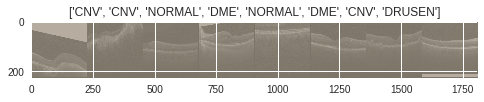

In [17]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
show_databatch(inputs, classes)

In [0]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    vgg.train(False)
    vgg.eval() # Set model for evaluation
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        print("BATCH {0}".format(i))
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            print("Using CUDA")
            inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
        else:
            inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
        
        outputs = vgg(inputs)
       
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

## Model creation

Freeze training for all layers except the last (fc) one

In [19]:
torch.backends.cudnn.benchmark = False
vgg16 = models.vgg16_bn(pretrained='imagenet')
print(vgg16.classifier[6].out_features)


# Remove last FC layer
for param in vgg16.parameters():
    param.require_grad = False
    
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) 
vgg16.classifier = nn.Sequential(*features) # Replace model classifier
print(vgg16)

# model = nn.Linear(num_features, len(class_names)) # Classifier as separated model for reduced memory



1000
VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (7): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (9): ReLU(inplace)
    (10): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (14): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): ReLU(inplace

In [0]:
resume_training = False

if resume_training:
    print("Loading pretrained model..")
    vgg16.load_state_dict(torch.load('VGG16_feature_extractor.pt'))
    print("Loaded!")

In [0]:
if use_gpu:
    vgg16.cuda()
    # model.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Memory debug utils

In [0]:
def pretty_size(size):
    """Pretty prints a torch.Size object"""
    assert(isinstance(size, torch.Size))
    return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
    """Prints a list of the Tensors being tracked by the garbage collector."""
    import gc
    total_size = 0
    for obj in gc.get_objects():
        try:
            if torch.is_tensor(obj):
                if not gpu_only or obj.is_cuda:
                    print("%s:%s%s %s" % (type(obj).__name__, 
                                          " GPU" if obj.is_cuda else "",
                                          " pinned" if obj.is_pinned else "",
                                          pretty_size(obj.size())))
                    total_size += obj.numel()
            elif hasattr(obj, "data") and torch.is_tensor(obj.data):
                if not gpu_only or obj.is_cuda:
                    print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
                                                   type(obj.data).__name__, 
                                                   " GPU" if obj.is_cuda else "",
                                                   " pinned" if obj.data.is_pinned else "",
                                                   " grad" if obj.requires_grad else "", 
                                                   " volatile" if obj.volatile else "",
                                                   pretty_size(obj.data.size())))
                    total_size += obj.data.numel()
        except Exception as e:
            pass        
    print("Total size:", total_size)

dump_tensors()

## Model visualization (before training)

Test before training
BATCH 0
Using CUDA
Ground truth:


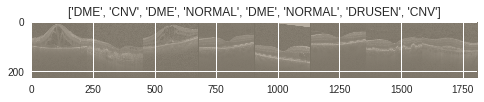

Prediction:


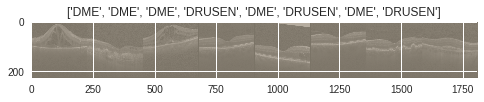

In [22]:
print("Test before training")
visualize_model(vgg16) #test before training

## Training

In [0]:
from livelossplot import PlotLosses

def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    liveloss = PlotLosses()
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    val_batches = len(dataloaders['val'])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        for i, data in enumerate(dataloaders['train']):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
            
            vgg.train(True)
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            # features = vgg(inputs)
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.data[0]
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
        
        for i, data in enumerate(dataloaders['val']):
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
            # print("Validation batch {}".format(i))
            
            vgg.train(False)
            vgg.eval()
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda(), volatile=True)
            else:
                inputs, labels = Variable(inputs, volatile=True), Variable(labels, volatile=True)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.data[0]
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes['val']
        avg_acc_val = acc_val / dataset_sizes['val']
        
        
        
        liveloss.update({
            'avg_loss': avg_loss,
            'avg_loss_val': avg_loss_val,
            'avg_acc': avg_acc,
            'avg_acc_val': avg_acc_val
        })
        liveloss.draw()
        
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg
        
            
            

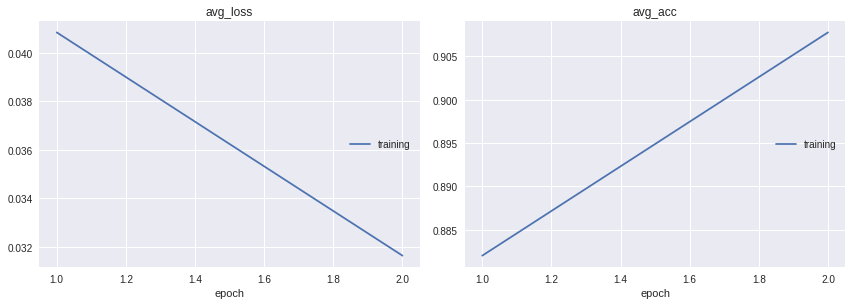

Epoch 1 result: 
Avg loss (train): 0.0316
Avg acc (train): 0.9077
Avg loss (val): 0.0030
Avg acc (val): 0.9960
----------


Training completed in 266m 60s
Best acc: 0.9960


In [24]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)

## Model visualization (after training)

Test after training
BATCH 0
Using CUDA
Ground truth:


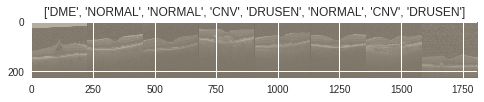

Prediction:


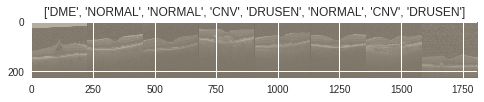

BATCH 1
Using CUDA
Ground truth:


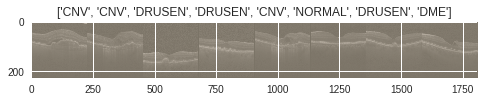

Prediction:


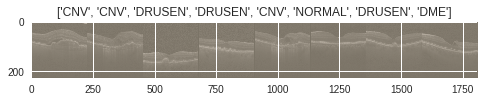

BATCH 2
Using CUDA
Ground truth:


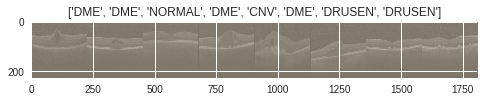

Prediction:


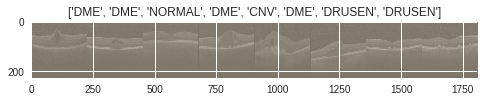

BATCH 3
Using CUDA
Ground truth:


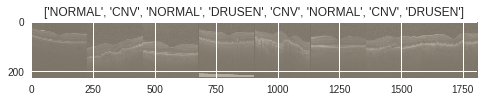

Prediction:


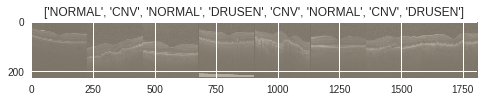

In [33]:
print("Test after training")
visualize_model(vgg16, num_images=32)

In [0]:
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Retina.pt')

In [35]:
if use_colab:
    from google.colab import files
    files.download('VGG16_v2-OCT_Retina.pt')

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 53716, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 696, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

MessageError: ignored

In [0]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)

In [0]:
print("Test after training")
visualize_model(vgg16, num_images=16)
torch.save(vgg16.state_dict(), 'VGG16_v2-OCT_Retina.pt')

In [0]:
if use_colab:
    from google.colab import files
    files.download('VGG16_v2-OCT_Retina.pt')